<a href="https://colab.research.google.com/github/christianboris/DSR_210_notebooks/blob/main/DSR_36_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(dataset_train_original, dataset_validate_original, dataset_test_original), info = tfds.load(
    name="cats_vs_dogs",
    split=["train[:70%]", "train[70%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True
)
print(info)
print("Train:   ", len(list(dataset_train_original)))
print("Validate:", len(list(dataset_validate_original)))
print("Test:    ", len(list(dataset_test_original)))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteD7373L/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmpo_tx76p3tfds'),
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-i

In [ ]:
image_size = 72
batch_size = 128

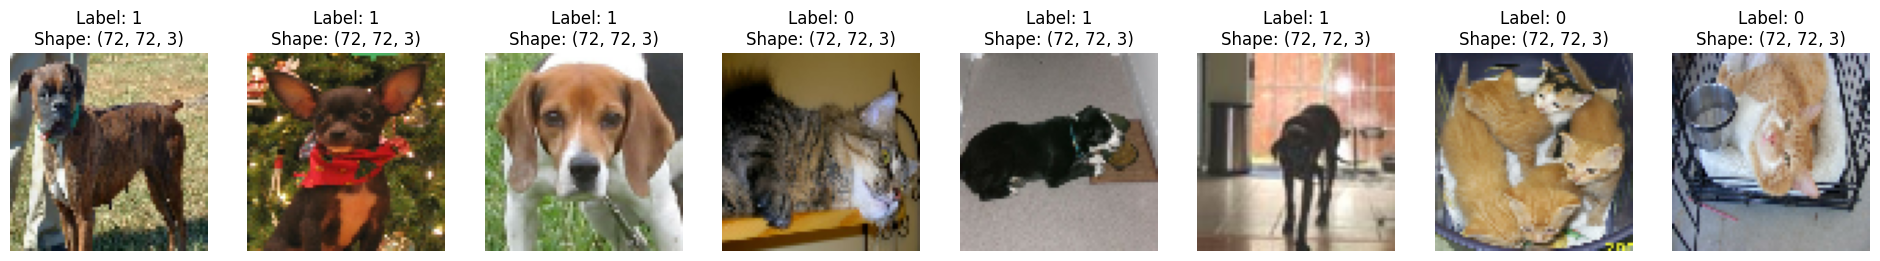

In [ ]:
def encode(image, label):
    image_encoded = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image_encoded = tf.image.resize(image_encoded, (image_size, image_size))
    return image_encoded, label

dataset = dataset_train_original.map(lambda image, label: encode(image, label))

index = 1
num_samples = 8
plt.figure(figsize=(24, 4))
for image, label in dataset.take(num_samples):
    plt.subplot(1, num_samples, index)
    plt.imshow(image)
    plt.title(f"Label: {label}\nShape: {image.shape}")
    plt.axis("off")
    index += 1

In [ ]:
dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache().shuffle(17_000).batch(batch_size)
dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache().batch(batch_size)
dataset_test = dataset_test_original.map(lambda image, label: encode(image, label)).cache().batch(batch_size)

In [ ]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

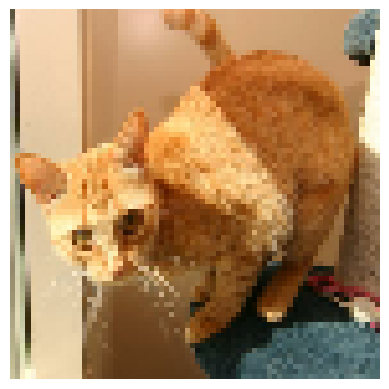

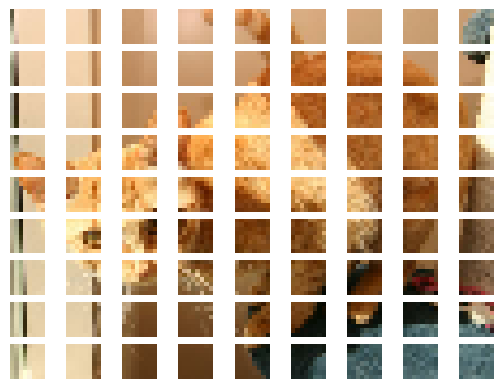

In [ ]:
patch_size = 8

dataset = dataset_train_original.map(lambda image, label: encode(image, label)).shuffle(100).batch(1)
patches_layer = Patches(patch_size=patch_size)

for image_batch, _ in dataset.take(1):

    # Render original image.
    plt.imshow(image_batch[0])
    plt.axis("off")
    plt.show()

    # Render patches.
    patches = patches_layer(image_batch)
    n = int(np.sqrt(patches.shape[1]))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        plt.imshow(patch_img.numpy())
        plt.axis("off")


In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

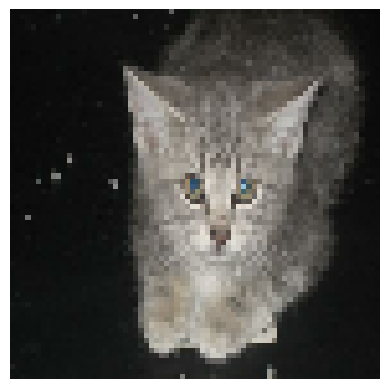

(81, 64)


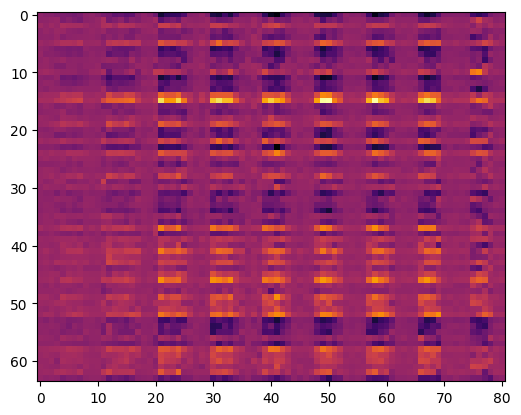

In [ ]:
patch_size = 8
num_patches = (image_size // patch_size) ** 2
embed_dim = 64 # Consider going down.

dataset = dataset_train_original.map(lambda image, label: encode(image, label)).shuffle(100).batch(1)
patches_layer = Patches(patch_size=patch_size)
patch_encoder_layer = PatchEncoder(num_patches=num_patches, projection_dim=embed_dim)

for image_batch, _ in dataset.take(1):

    # Render original image.
    plt.imshow(image_batch[0])
    plt.axis("off")
    plt.show()

    # Render encoded patches.
    patches = patches_layer(image_batch)
    patch_encoding = patch_encoder_layer(patches)
    plt.imshow(patch_encoding[0].numpy().transpose(), cmap="inferno")
    print(patch_encoding[0].shape)


In [ ]:
from IPython.utils.text import num_ini_spaces
class TransformerEncoder(layers.Layer):

    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)

        # Function variables/parameters/argument -> instance variables. Saving 'em 4 later.
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Create the layers.
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.mlp = tf.keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs):
        normalized_inputs = self.layernorm_1(inputs)
        attention_outputs = self.attention(normalized_inputs, normalized_inputs)
        sum = inputs + attention_outputs # RESIDUAL CONNECTION!!!
        normalized_sum = self.layernorm_2(sum)
        mlp_output = self.mlp(normalized_sum)
        result = sum + mlp_output # RESIDUAL CONNECTION!!!
        return result

encoder = TransformerEncoder(64, 128, 4)
sample = np.random.random((1, 81, 64))
encoder(sample)

<tf.Tensor: shape=(1, 81, 64), dtype=float32, numpy=
array([[[ 0.7420363 ,  0.45474488, -0.0197531 , ..., -0.5141567 ,
          0.0035587 ,  1.4708755 ],
        [ 0.1573661 ,  0.9965558 , -0.40318573, ...,  0.6674678 ,
         -0.20511688, -0.14677982],
        [-0.16746117,  0.10977238, -0.25018233, ...,  0.98511803,
         -0.71706426, -0.26492417],
        ...,
        [ 0.9161778 ,  0.50394785,  0.1333648 , ..., -0.53941435,
         -0.4999172 ,  0.7015823 ],
        [ 0.6741465 ,  1.0835168 ,  0.7549809 , ...,  0.88813996,
          0.45323747,  0.9099508 ],
        [ 0.3307183 ,  0.7442805 ,  1.3553693 , ...,  0.65513206,
          0.06177652,  1.272207  ]]], dtype=float32)>

In [ ]:
patch_size = 8
num_patches = (image_size // patch_size) ** 2
num_heads = 4
num_encoders =  2
embed_dim = 64

model = models.Sequential()
model.add(layers.Input(shape=(image_size, image_size, 3)))
model.add(Patches(patch_size=patch_size))
model.add(PatchEncoder(num_patches=num_patches, projection_dim=embed_dim))
for _ in range(num_encoders):
    model.add(TransformerEncoder(embed_dim=embed_dim, dense_dim=embed_dim * 2, num_heads=num_heads))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs=50,
    validation_data=dataset_validate
)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches_10 (Patches)        (None, None, 192)         0         
                                                                 
 patch_encoder_8 (PatchEnco  (None, 81, 64)            17536     
 der)                                                            
                                                                 
 transformer_encoder_14 (Tr  (None, 81, 64)            83200     
 ansformerEncoder)                                               
                                                                 
 transformer_encoder_15 (Tr  (None, 81, 64)            83200     
 ansformerEncoder)                                               
                                                                 
 global_max_pooling1d_3 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                   

AttributeError: ignored